In [1]:
from tqdm import tqdm
import numpy as np  

In [2]:
# read rating data
# construct data{} and item_rating{}
data_path = '../data/train.txt'

centerlize = False  # centerlize the rating data or not

train_lines = 0
all_avg = 0
item_rating= {}

with open(data_path, 'r') as f:
    lines = f.readlines()
    user_id = None
    train_lines = len(lines)
    data = {}
    for line in lines:
        line = line.strip()
        if '|' in line:  # user line
            train_lines -= 1
            if(user_id != None and centerlize == True):
                avg = data[user_id]['sum'] / data[user_id]['num_ratings']
                data[user_id]['ratings'].update({k: v - avg for k, v in data[user_id]['ratings'].items()})
                data[user_id]['norm'] = sum(x**2 for x in data[user_id]['ratings'].values())**0.5

            user_id, num_ratings = line.split('|')
            user_id = int(user_id)
            data[user_id] = {}
            data[user_id]['num_ratings'] = int(num_ratings)
            data[user_id]['ratings'] = {}
            data[user_id]['sum'] = 0
        else:  # rating line
            item_id, score = map(int, line.split())
            data[user_id]['ratings'][item_id] = score
            data[user_id]['sum'] += score
            all_avg += score
            if item_id not in item_rating:
                item_rating[item_id] = {'num': 0, 'sum': 0}
            item_rating[item_id]['num'] += 1
            item_rating[item_id]['sum'] += score
    if centerlize == True:
        avg = data[user_id]['sum'] / data[user_id]['num_ratings']
        data[user_id]['ratings'].update({k: v - avg for k, v in data[user_id]['ratings'].items()})
        data[user_id]['norm'] = sum(x**2 for x in data[user_id]['ratings'].values())**0.5

all_avg /= train_lines
lines = None

In [3]:
bias = {} #用户偏差
for userid in data.keys():
    bias[userid] = data[userid]['sum']/data[userid]['num_ratings'] - all_avg
item_bias = {} #物品偏差
for itemid in item_rating.keys():
    item_bias[itemid] = item_rating[itemid]['sum']/item_rating[itemid]['num'] - all_avg

In [ ]:
#cacluate similarity between users
#takes 1 hour 20mins
similarity = {}
for i, (userid1, user1_data) in tqdm(enumerate(data.items()), total=len(data)):
    similarity[userid1] = {}
    for j, (userid2, user2_data) in enumerate(data.items()):
        if i >= j:
            continue
        if  user1_data['norm'] == 0 or  user2_data['norm'] == 0:
            similarity[userid1][userid2] = 0
            continue
        else:
            cos_sim = 0.0
            for item, rating in user1_data['ratings'].items():
                if item in user2_data['ratings']:
                    cos_sim += rating * user2_data['ratings'][item]
            cos_sim = cos_sim / (user1_data['norm'] * user2_data['norm'])
            similarity[userid1][userid2] = cos_sim

100%|██████████| 19835/19835 [1:23:37<00:00,  3.95it/s]  


In [ ]:
# save similarity matrix
np.save('similarity.npy', similarity)

In [6]:
# load similarity matrix
similarity = np.load('similarity.npy', allow_pickle=True).item()

In [4]:
#read test data
test_input = {}
with open('../data/test.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip()  # 去除行尾的换行符
        if '|' in line:
            # 这是一个用户的开始
            userid, num_items = line.split('|')  # 分割用户ID和评分项目数量
            userid = int(userid)
            test_input[userid] = {'num_items': int(num_items), 'items': []}
        else:
            # 这是一个项目ID
            itemid = int(line)
            test_input[userid]['items'].append(itemid)
lines = None

In [5]:
import heapq
def find_top_N_keys(user_id, n, item_id = None, only_keys = True):
    all_similarity = [(i,similarity[i][user_id]) for i in range(user_id)]
    all_similarity.extend(list(similarity[user_id].items()))
    if item_id == None: #不要求item_id在dictionary中
        top_n_items = heapq.nlargest(n, all_similarity, key=lambda x: x[1])
    else:   
        top_n_items = heapq.nlargest(n, ((k, v) for (k, v) in all_similarity if item_id in data[k]['ratings']), key=lambda item: item[1])
    if only_keys:
        top_n_keys = [key for (key, value) in top_n_items ]
        return top_n_keys
    else:
        return top_n_items

In [13]:
'''
this section of code is for testing when writing report
'''
unable_converge = {}
initial_lr = 1e-3
epsilon = 100
beta1 = 0.9
beta2 = 0.999
eps = 1e-8
t = 0

epsilon = 10
weight = {}
userid = 2
R = len(data[userid]['ratings'])
print("R:",R)
N = 300
N_neighbor = find_top_N_keys(userid, N, only_keys=False) #为了加速计算，只选择相似度最高的N个邻居  (userid, similarity)
sim_sum = np.sum([sim for (id,sim) in N_neighbor])
w = np.array([sim/sim_sum for (id,sim) in N_neighbor])  #初始化权重, 并归一化

m = np.zeros_like(w)
v = np.zeros_like(w)

rating_matrix = np.zeros((N, len(data[userid]['ratings'])))
true_rating = np.array(list(data[userid]['ratings'].values()))
user_bias = np.zeros(len(data[userid]['ratings']))

grad = np.zeros(N)
for i,itemid in enumerate(data[userid]['ratings'].keys()):
    user_bias[i] = bias[userid] + item_bias[itemid] + all_avg
    for j,(neighbor,sim_) in enumerate(N_neighbor):
        if itemid in data[neighbor]['ratings']: 
            rating_matrix[j][i] = data[neighbor]['ratings'][itemid]  - (bias[neighbor] + item_bias[itemid] + all_avg)
        else:
            rating_matrix[j][i] = 0
RMSE = []
while True:
    t += 1
    eval = np.dot(w, rating_matrix) 
    nonzero_indices = np.nonzero(eval)
    eval[nonzero_indices] += user_bias[nonzero_indices]
    
    loss = np.sum((eval[nonzero_indices] - true_rating[nonzero_indices])**2)
    grad = np.array([(2*(eval - true_rating) * rating_matrix[N_neighbor.index(n)]).sum() for n in N_neighbor])
    MSE = loss/R

    # Adam update
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)
    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)
    w_old = w
    w = w - initial_lr * m_hat / (np.sqrt(v_hat) + eps)
    #print("MSE: ",MSE)
    print("Loss: ",loss)
    RMSE.append(MSE)
    if(MSE < epsilon**2):
        break
weight[userid] = w

R: 101
Loss:  70990.14766245506
Loss:  63224.75400912321
Loss:  58138.03708427603
Loss:  55215.18432918807
Loss:  53606.510213935
Loss:  52483.734615110414
Loss:  51319.75565601835
Loss:  49899.00848654148
Loss:  48204.63501121944
Loss:  46321.0494546423
Loss:  44372.70461568493
Loss:  42485.532283559995
Loss:  40761.58247580128
Loss:  39263.23242267054
Loss:  38006.36553159736
Loss:  36963.10694478973
Loss:  36074.07225586081
Loss:  35267.62291188222
Loss:  34480.60732890385
Loss:  33673.92360019514
Loss:  32838.402862360614
Loss:  31990.694003452933
Loss:  31162.337633009658
Loss:  30386.578422713155
Loss:  29687.035214323518
Loss:  29071.066269448813
Loss:  28529.07080148796
Loss:  28039.231107078136
Loss:  27575.59419775882
Loss:  27116.455632487367
Loss:  26650.200719585504
Loss:  26177.00187284178
Loss:  25706.43404557829
Loss:  25252.419922359324
Loss:  24827.547074306334
Loss:  24438.690237275016
Loss:  24085.20564060237
Loss:  23759.985120675585
Loss:  23452.656590443345
Loss:

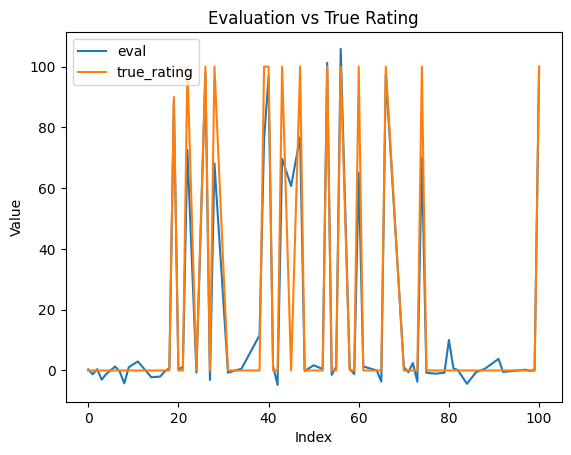

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=nonzero_indices[0], y=eval[nonzero_indices], label='eval')
sns.lineplot(x=nonzero_indices[0], y=true_rating[nonzero_indices], label='true_rating')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Evaluation vs True Rating')
plt.legend()

plt.show()


In [16]:
num_values = [item_rating[i]['num'] for i in item_rating.keys()]
avg = np.average(num_values)
print(avg)

10.975654555389507


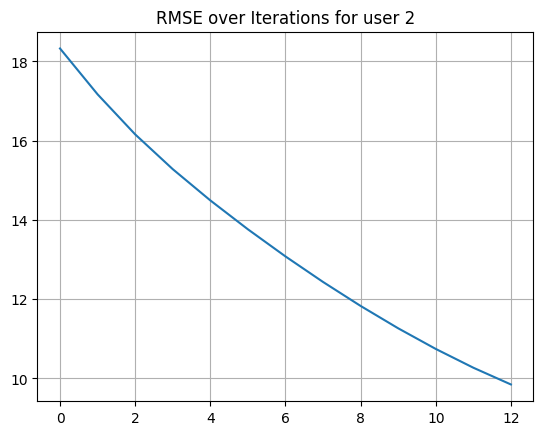

In [347]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=range(len(RMSE)), y=np.sqrt(RMSE))
plt.title("RMSE over Iterations for user 2")
plt.grid(True)


In [375]:
def get_interpolation_weight(userid, itemid, N = 10):
    initial_lr = 1e-2
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8
    t = 0     

    epsilon = 10 #收敛条件，RMSE小于10停止
    N_neighbor = find_top_N_keys(userid, N, item_id = itemid,only_keys=False) #为了加速计算，只选择相似度最高的N个邻居
    N = len(N_neighbor) #实际邻居数量

    sim_sum = np.sum([sim for (id,sim) in N_neighbor])
    if(sim_sum == 0):
        return None
    w = np.array([sim/sim_sum for (id,sim) in N_neighbor])  #初始化权重, 并归一化
    
    mse_eps = 1
    mse_old = 0

    m = np.zeros_like(w)
    v = np.zeros_like(w) #Adam参数

    rating_matrix = np.zeros((N, len(data[userid]['ratings']))) #评分矩阵
    true_rating = np.array(list(data[userid]['ratings'].values())) #真实评分，作为标签
    user_bias = np.zeros(len(data[userid]['ratings']))  #用户偏差

    grad = np.zeros(N)
    #初始化评分矩阵
    for i,itemid in enumerate(data[userid]['ratings'].keys()): #因为计算时有w *（r_yi - b_yi），所以这里先将(r_yi - b_yi)算出来
        user_bias[i] = bias[userid] + item_bias[itemid] + all_avg
        for j,(neighbor,sim_) in enumerate(N_neighbor):
            if itemid in data[neighbor]['ratings']: 
                rating_matrix[j][i] = data[neighbor]['ratings'][itemid]  - (bias[neighbor] + item_bias[itemid] + all_avg)
            else:
                rating_matrix[j][i] = 0
    #迭代训练
    while True:
        t += 1 #迭代次数，用于Adam更新
        eval = np.dot(w, rating_matrix)  #使用矩阵乘法形式，加速计算
        nonzero_indices = np.nonzero(eval)
        eval[nonzero_indices] += user_bias[nonzero_indices]  #加上用户偏差，得到最终预测评分   
         
        loss = np.sum((eval[nonzero_indices] - true_rating[nonzero_indices])**2) #计算损失
        grad = np.array([(2*(eval - true_rating) * rating_matrix[N_neighbor.index(n)]).sum() for n in N_neighbor])
        MSE = loss/len(nonzero_indices[0])

        # Adam update
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        diff = abs(MSE - mse_old)
        if(diff < mse_eps):
            break
        mse_old = MSE
        w = w - initial_lr * m_hat / (np.sqrt(v_hat) + eps)
        if(MSE < epsilon**2):
            break
    W = {k: v for (k,k1), v in zip(N_neighbor, w)}
    #print(eval[nonzero_indices])
    #print(true_rating[nonzero_indices])
    return W

In [395]:
#this section of code is for single test
user_id = 4
item_id = 333773
W1 = get_interpolation_weight(user_id, item_id, N = 10)
eval = 0
for neighbor in W1.keys():
            eval += W1[neighbor] * (data[neighbor]['ratings'][item_id] - (bias[neighbor] + item_bias[item_id] + all_avg))
baseline =bias[user_id] + item_bias[item_id] + all_avg
eval += baseline
print(eval)


67.32951037562269


In [393]:
#takes 1-2 hours
test_output = {}

for user_id, user_data in (tqdm(test_input.items())):
    user_id = int(user_id)
    test_output[user_id] = {}
    for item_id in user_data['items']:
        item_id = int(item_id)
        eval = 0
        sim_sum = 0
        if item_id not in item_rating: #物品没有评分
            test_output[user_id][item_id] = int(data[user_id]['sum']/data[user_id]['num_ratings']) #直接用用户的平均评分
            continue
        W = get_interpolation_weight(user_id, item_id, 10) #插值权重
        if W == None: #无法插值
            test_output[user_id][item_id] = data[user_id]['sum']/data[user_id]['num_ratings']
            continue
        for neighbor in W.keys():
            eval += W[neighbor] * (data[neighbor]['ratings'][item_id] - (bias[neighbor] + item_bias[item_id] + all_avg))
        
        baseline =bias[user_id] + item_bias[item_id] + all_avg
        eval += baseline
        eval = min(100, eval)
        eval = max(0, eval)
        test_output[user_id][item_id] = int(eval)
            

print('evaluate done')

result_path = 'result_weighted.txt'
with open(result_path, 'w') as f:
    for userid, item_list in test_output.items():
        f.write(f"{userid}|6\n")
        for item, rating in item_list.items():
            f.write(f"{item}  {rating}\n")

print('write done')

100%|██████████| 19835/19835 [55:21<00:00,  5.97it/s]  

evaluate done
write done
